## What is VQ-VAE?

* VQ-VAE is a type of autoencoder that uses discrete latent embeddings instead of continuous latent variables like in a traditional VAE.
* The encoder maps input data to a discrete latent representation by quantizing the output using a set of learned embedding vectors (codebook).

## Key Components of VQ-VAE:

    Encoder: Maps input data to a latent space.
    Codebook (Embedding Space):
        Contains a fixed number of discrete latent vectors (codewords).
        Each vector represents a cluster in the latent space.
    Quantization:
        Maps the continuous latent vector from the encoder to the nearest discrete codeword in the codebook.
    Decoder: Reconstructs the input data using the quantized latent representation.

## Details about Codebook

* The codebook (or embedding space) is a fixed-size set of discrete vectors, also called codewords.
* It’s essentially a learnable lookup table where each codeword is a vector in the latent space.
* The encoder’s continuous output is replaced (quantized) by the nearest codeword from the codebook.

### Structure of Codebook


The codebook is represented as a matrix of size:

\[
\text{Codebook} = \mathbb{R}^{K \times D}
\]

Where:
- \( K \): The number of discrete embeddings (codewords) in the codebook (e.g., \( K = 512 \)).
- \( D \): The dimensionality of each codeword (e.g., \( D = 64 \)).

For example, if \( K = 512 \) and \( D = 64 \), the codebook contains 512 discrete embeddings, each with 64 dimensions.




## **How Does the Codebook Work?**

The **codebook** plays a key role during encoding and decoding. Here’s the step-by-step process:

---

### **1. Quantization**

The encoder outputs a continuous latent vector \( z_e(x) \). Instead of using this directly, the model **quantizes** \( z_e(x) \) to the nearest codeword from the codebook.

\[
z_q(x) = e_k, \quad \text{where } k = \arg\min_j || z_e(x) - e_j ||_2^2
\]

- \( z_q(x) \): Quantized latent vector (output of the quantization step).
- \( z_e(x) \): Continuous latent vector produced by the encoder.
- \( e_j \): \( j \)-th codeword in the codebook.
- \( || \cdot ||_2^2 \): Squared Euclidean distance.

**Intuition**:
The quantization step replaces the continuous output \( z_e(x) \) with the **nearest discrete vector** \( e_k \), enabling the latent space to become **discrete**.

---

### **2. Reconstruction**

The decoder reconstructs the input \( x \) using the quantized latent representation \( z_q(x) \):

\[
\hat{x} = f_{\text{dec}}(z_q(x))
\]

- \( f_{\text{dec}} \): The decoder function.
- \( \hat{x} \): Reconstructed input.

The decoder operates only on the quantized representation, effectively treating the latent space as discrete.

---

### **3. Gradient Flow and Training**

Quantization introduces a problem: the **nearest-neighbor selection** step is non-differentiable, which makes it impossible to backpropagate gradients through the codebook directly. To solve this, **gradient approximation techniques** are used:

1. **Stop Gradient (\( \text{sg} \))**:
   - During the forward pass, the encoder’s output \( z_e(x) \) is quantized to the nearest codeword.
   - During the backward pass, gradients are passed through \( z_e(x) \) as if quantization did not occur. This is called the **straight-through estimator (STE)**.

   Forward:
   \[
   z_q(x) = e_k
   \]

   Backward:
   \[
   \frac{\partial L}{\partial z_e(x)} = \frac{\partial L}{\partial z_q(x)}
   \]

2. **Separate Updates for Codebook**:
   - The codebook embeddings \( \{e_j\} \) are updated using a **codebook loss**, which encourages the codebook vectors to move closer to the encoder’s outputs \( z_e(x) \).

---

### **Benefits of the Codebook**

1. **Discrete Representations**:
   - The quantized latent space forces the model to use a finite set of embeddings, which is useful for tasks requiring symbolic or categorical representations.

2. **Interpretability**:
   - Each codeword can represent a specific cluster of features in the input data, making the latent space more structured and interpretable.

3. **Compactness**:
   - By using discrete codewords, the model can compress the latent space effectively, leading to better generalization.

4. **Flexibility**:
   - The size of the codebook (\( K \)) and the dimensionality of each embedding (\( D \)) can be adjusted to control the granularity of the latent space.

---

## **Key Takeaways**

| **Step**              	| **Explanation**                                                                              	|
|---------------------------|--------------------------------------------------------------------------------------------------|
| **Initialization**     	| Creates \( K \) discrete vectors of size \( D \), forming the codebook.                     	|
| **Quantization**       	| Maps the encoder output \( z_e(x) \) to the nearest codeword \( e_k \).                     	|
| **Codebook Update**    	| Moves \( e_k \) closer to \( z_e(x) \) (codebook loss).                                     	|
| **Encoder Update**     	| Encourages \( z_e(x) \) to commit to \( e_k \) (commitment loss).                           	|
| **Decoder**            	| Uses the quantized latent vector \( z_q(x) \) to reconstruct the input.                    	|
| **Result**             	| Discrete latent space representation that is compact , interpretable, and structured.        	|











### Who Creates the Codebook in VQ-VAE?

The **codebook** in **VQ-VAE** is **learned during training**. It is not precomputed or predefined; instead, the model learns the embeddings (codewords) in the codebook dynamically as part of the training process.

---

### When Does Codebook Creation Happen?

The **codebook is initialized at the start of training** and updated throughout the training process based on the interaction between the encoder's output and the nearest codeword assignments. Here's the sequence:

1. **Initialization**:
   - The codebook is initialized when the model is created.
   - It starts as a matrix of random embeddings (codewords).
   - Size of the codebook: \( K \times D \), where \( K \) is the number of discrete codewords and \( D \) is their dimensionality.

   Example in PyTorch:
   ```python
   self.codebook = nn.Embedding(num_embeddings=K, embedding_dim=D)
   self.codebook.weight.data.uniform_(-1 / K, 1 / K)
   ```

2. **Quantization Step**:
   - During training, the encoder outputs a continuous latent vector \( z_e(x) \).
   - The quantization step assigns each \( z_e(x) \) to its nearest codeword \( e_k \) in the codebook.

   Formula:
   \[
   z_q(x) = e_k, \quad \text{where } k = \arg\min_j || z_e(x) - e_j ||_2^2
   \]
   This step uses the nearest-neighbor selection to find the closest codeword.

3. **Codebook Updates**:
   - The codebook vectors \( \{e_k\} \) are updated during backpropagation based on the **codebook loss**:
     \[
     L_{\text{codebook}} = || \text{sg}[z_e(x)] - e_k ||_2^2
     \]
   - This loss encourages the selected codeword \( e_k \) to move closer to the encoder output \( z_e(x) \).

4. **Commitment Updates**:
   - The encoder is updated using the **commitment loss** to ensure \( z_e(x) \) commits to a specific codeword:
     \[
     L_{\text{commit}} = \beta || z_e(x) - \text{sg}[e_k] ||_2^2
     \]
   - This indirectly refines the codebook as the encoder learns to produce outputs closer to the discrete embeddings.

---

### Key Points About Codebook Creation

1. **Learnable Parameters**:
   - The codebook embeddings are **learnable parameters** of the model, just like the weights in the encoder and decoder.
   - These parameters are optimized during training using the backpropagation algorithm.

2. **Dynamic Updates**:
   - The codebook evolves throughout training as the encoder and decoder improve.
   - Initially, the codebook embeddings are random, but over time, they adapt to represent clusters of features in the input data.

3. **Separate Loss for Codebook**:
   - The codebook is updated independently of the encoder through the **codebook loss**.
   - This ensures that the embeddings represent meaningful latent clusters.

---

### Why Is the Codebook Created Dynamically?

1. **Data-Specific Representation**:
   - The codebook adapts to the dataset being used, learning embeddings that represent meaningful features or patterns in the data.

2. **Compact Latent Space**:
   - By clustering the encoder's continuous outputs into discrete regions, the codebook creates a compact latent space with structured and interpretable representations.

3. **Avoids Predefined Bias**:
   - Instead of manually defining embeddings (which may not suit the data), the codebook learns directly from the data during training.

---

### Summary

- **Who creates the codebook?**
  - The model itself learns the codebook embeddings as part of the training process.

- **When is the codebook created?**
  - The codebook is initialized at the start of training and updated dynamically during backpropagation using the codebook loss and the encoder's outputs.

- **How is it updated?**
  - Through the **codebook loss**, which aligns codebook embeddings with the encoder’s output, and the **commitment loss**, which regularizes the encoder to commit to specific codewords.



# **Loss Functions in VQ-VAE**

The **Vector Quantized Variational Autoencoder (VQ-VAE)** employs multiple loss terms to ensure proper training. These losses balance the reconstruction quality, the alignment of the latent representations with the codebook, and the commitment of the encoder to specific codebook embeddings.

---

## **1. Reconstruction Loss**

### **Formula**:
\[
L_{\text{recon}} = || x - \hat{x} ||_2^2
\]

### **Purpose**:
- Measures the pixel-wise difference between the original input \( x \) and the reconstructed output \( \hat{x} \).
- Encourages the decoder to produce images that closely match the original input.

### **How it Works**:
1. The decoder reconstructs \( \hat{x} \) using the **quantized latent vector** \( z_q(x) \).
2. The reconstruction loss computes the error between \( x \) and \( \hat{x} \).

### **Variants**:
- For continuous data:
  - **Mean Squared Error (MSE)** is used:
    \[
    L_{\text{recon}} = \frac{1}{N} \sum_{i=1}^N (x_i - \hat{x}_i)^2
    \]
  - Here, \( x_i \) is the pixel intensity of the original image, and \( \hat{x}_i \) is the pixel intensity of the reconstructed image.

- For binary or normalized data (\([0, 1]\)):
  - **Binary Cross-Entropy (BCE)** is commonly used:
    \[
    L_{\text{recon}} = -\sum_{i} \left[ x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i) \right]
    \]

---

## **2. Codebook Loss**

### **Formula**:
\[
L_{\text{codebook}} = || \text{sg}[z_e(x)] - e_k ||_2^2
\]

### **Purpose**:
- Ensures that the selected codeword \( e_k \) (from the codebook) moves closer to the encoder’s continuous output \( z_e(x) \).
- Updates the codebook embeddings \( \{e_k\} \) so they represent the latent space effectively.

### **Key Terms**:
- \( z_e(x) \): Continuous latent representation output by the encoder.
- \( \text{sg} \): Stop-gradient operation, which prevents gradients from flowing back to \( z_e(x) \).

### **Explanation**:
- The loss minimizes the distance between \( \text{sg}[z_e(x)] \) (treated as a constant) and \( e_k \) (codeword).
- Gradients flow only to the **codebook vectors**, updating the embeddings.

### **Why Needed**:
Without this loss, the codebook embeddings \( e_k \) would not adapt to the encoder's output, leading to a poorly learned latent space.

---

## **3. Commitment Loss**

### **Formula**:
\[
L_{\text{commit}} = || z_e(x) - \text{sg}[e_k] ||_2^2
\]

### **Purpose**:
- Ensures that the encoder output \( z_e(x) \) stays close to the selected codeword \( e_k \), preventing the encoder from "hovering" between multiple codewords.
- Encourages the encoder to **commit** to specific codewords.

### **Key Terms**:
- \( \text{sg}[e_k] \): Treated as a constant during the backward pass, so only the encoder parameters are updated.

### **Explanation**:
- This term regularizes the encoder by penalizing differences between \( z_e(x) \) and \( e_k \).
- The commitment strength is controlled by a hyperparameter \( \beta \).

---
### Beta term why used in only commitment loss

| **Beta Term**          	| **Purpose**                                                                              	| **Why No \( \beta \)?**                                                                                	|
|----------------------------|----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| **Reconstruction Loss** 	| Ensures accurate reconstructions of the input \( x \).                                  	| It's the primary objective and should always dominate the optimization process.                      	|
| **Codebook Loss**       	| Updates the codebook embeddings \( e_k \) to align with the encoder's outputs \( z_e(x) \). | It operates independently of the encoder and decoder, so scaling is unnecessary.                     	|
| **Commitment Loss**     	| Regularizes \( z_e(x) \) to move closer to \( e_k \).                                   	| \( \beta \) is needed to control the trade-off between reconstruction quality and encoder regularization. |

By design, \( \beta \) is used only in the **commitment loss** because it regulates a trade-off specific to the encoder, while the other losses serve their purposes without needing scaling.


---

## **4. Total VQ-VAE Loss**

### **Formula**:
\[
L_{\text{VQ-VAE}} = L_{\text{recon}} + L_{\text{codebook}} + \beta L_{\text{commit}}
\]

### **Purpose**:
- Combines the reconstruction loss, codebook loss, and commitment loss to jointly train the encoder, decoder, and codebook embeddings.

### **Explanation**:
- **Reconstruction Loss** trains the decoder to accurately reconstruct the input.
- **Codebook Loss** ensures the discrete latent space aligns with the encoder’s outputs.
- **Commitment Loss** regularizes the encoder to commit to specific codewords.

### **Role of \( \beta \)**:
- \( \beta \) scales the commitment loss. A higher \( \beta \) enforces stronger commitment, while a lower \( \beta \) allows the encoder more flexibility.
-  Higher β: Forces tighter commitment to codewords but risks over-regularization, which might harm reconstruction quality.
- Lower β: Allows more encoder flexibility but may result in a poorly utilized codebook.

By making β a tunable parameter, we can control the degree of regularization applied to the encoder.

---

## **Alternative: Soft Quantization**

In some cases, a **soft quantization** is used instead of the nearest-neighbor selection to make the quantization process differentiable.

### **Formula for Soft Quantization**:
\[
z_q(x) = \sum_{j} w_j e_j, \quad w_j = \frac{\exp(-|| z_e(x) - e_j ||_2^2)}{\sum_k \exp(-|| z_e(x) - e_k ||_2^2)}
\]

- \( w_j \): Weight of the \( j \)-th codeword, determined by its distance to \( z_e(x) \).
- This creates a weighted average of the codewords, making the process differentiable.

---

## **Summary of Loss Functions**

| **Loss Function**          | **Formula**                                    | **Purpose**                                                                                            |
|-----------------------------|-----------------------------------------------|--------------------------------------------------------------------------------------------------------|
| **Reconstruction Loss**     | \( || x - \hat{x} ||_2^2 \)                   | Ensures the decoder generates accurate reconstructions of the input data.                             |
| **Codebook Loss**           | \( || \text{sg}[z_e(x)] - e_k ||_2^2 \)       | Updates the codebook embeddings \( e_k \) to align with the encoder's latent space.                   |
| **Commitment Loss**         | \( \beta || z_e(x) - \text{sg}[e_k] ||_2^2 \) | Encourages the encoder to output latent vectors close to the selected codebook embeddings.            |
| **Total VQ-VAE Loss**       | \( L_{\text{recon}} + L_{\text{codebook}} + \beta L_{\text{commit}} \) | Combines all losses to jointly train the encoder, decoder, and codebook.                              |

---

## **Practical Implementation**

Here’s how the loss functions are implemented in PyTorch:

```python
# Reconstruction Loss
recon_loss = F.mse_loss(reconstructed_output, input_data)

# Codebook Loss
codebook_loss = F.mse_loss(quantized.detach(), encoder_output)

# Commitment Loss
commitment_loss = F.mse_loss(encoder_output, quantized.detach())

# Total Loss
beta = 0.25  # Hyperparameter for commitment strength
total_loss = recon_loss + codebook_loss + beta * commitment_loss
```

---

## **Training Dynamics**

1. **Early Training**:
   - \( L_{\text{recon}} \) is high because the decoder cannot reconstruct the input yet.
   - \( L_{\text{codebook}} \) is high because the codebook embeddings are not aligned with the encoder outputs.

2. **Mid Training**:
   - The decoder improves, reducing \( L_{\text{recon}} \).
   - The codebook aligns better with the encoder, stabilizing \( L_{\text{codebook}} \).

3. **Late Training**:
   - \( L_{\text{commit}} \) ensures stable and committed encoder outputs.
   - \( L_{\text{recon}} \) becomes very small, indicating high-quality reconstructions.

---

By combining these loss functions, **VQ-VAE** achieves a balance between reconstruction quality and structured, discrete latent representations. Let me know if you'd like further clarifications or detailed examples!

# Import Libraries and Dataset Loading

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# MNIST Dataset 

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1,1]
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Main VQVAE Model 

In [69]:
class VQVAE(nn.Module):
    # input_channels=1: Grayscale images (single channel).
    # embedding_dim=64e: Dimension of each codeword.
    # num_embeddings=512: Number of codewords in the codebook.
    def __init__(self, embedding_dim=64, num_embeddings=512):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(64, embedding_dim, kernel_size=3, stride=1, padding=1) # 7x7 -> 7x7
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)        #  embeddings are initialized randomly in the range [−1/num_embedding,1/num_embedding]
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, kernel_size=4, stride=2, padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 14x14 -> 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1), # 28x28 -> 28x28
            nn.Tanh()
        )

    # forward pass 
    def forward(self, x):
        # Encodes the input (x) into a latent representation (ze(x)).
        z_e = self.encoder(x)
        # Quantization
        flat_z_e = z_e.permute(0, 2, 3, 1).contiguous().view(-1, z_e.size(1))
        distances = (
            torch.sum(flat_z_e ** 2, dim=1, keepdim=True)
            + torch.sum(self.codebook.weight ** 2, dim=1)
            - 2 * torch.matmul(flat_z_e, self.codebook.weight.t())
        )
        indices = torch.argmin(distances, dim=1)
        z_q = self.codebook(indices).view(z_e.shape)
        
        # Decoding
        x_recon = self.decoder(z_q)
        # print("z_e shape:", z_e.shape)
        # print("z_q shape:", z_q.shape)
        # print("x_recon shape:", x_recon.shape)

        return x_recon, z_e, z_q, indices

       

# Train the model

Epoch 1/100, Loss: 0.4573
Epoch 2/100, Loss: 0.3925
Epoch 3/100, Loss: 0.3727
Epoch 4/100, Loss: 0.3554
Epoch 5/100, Loss: 0.3515
Epoch 6/100, Loss: 0.3518
Epoch 7/100, Loss: 0.3501
Epoch 8/100, Loss: 0.3499
Epoch 9/100, Loss: 0.3515
Epoch 10/100, Loss: 0.3489
Epoch 11/100, Loss: 0.3490
Epoch 12/100, Loss: 0.3486
Epoch 13/100, Loss: 0.3506
Epoch 14/100, Loss: 0.3487
Epoch 15/100, Loss: 0.3487
Epoch 16/100, Loss: 0.3487
Epoch 17/100, Loss: 0.3486
Epoch 18/100, Loss: 0.3486
Epoch 19/100, Loss: 0.3486
Epoch 20/100, Loss: 0.3486
Epoch 21/100, Loss: 0.3486
Epoch 22/100, Loss: 0.3485
Epoch 23/100, Loss: 0.3485
Epoch 24/100, Loss: 0.3486
Epoch 25/100, Loss: 0.3485
Epoch 26/100, Loss: 0.3485
Epoch 27/100, Loss: 0.3485
Epoch 28/100, Loss: 0.3485
Epoch 29/100, Loss: 0.3485
Epoch 30/100, Loss: 0.3485
Epoch 31/100, Loss: 0.3485
Epoch 32/100, Loss: 0.3485
Epoch 33/100, Loss: 0.3485
Epoch 34/100, Loss: 0.3484
Epoch 35/100, Loss: 0.3485
Epoch 36/100, Loss: 0.3485
Epoch 37/100, Loss: 0.3485
Epoch 38/1

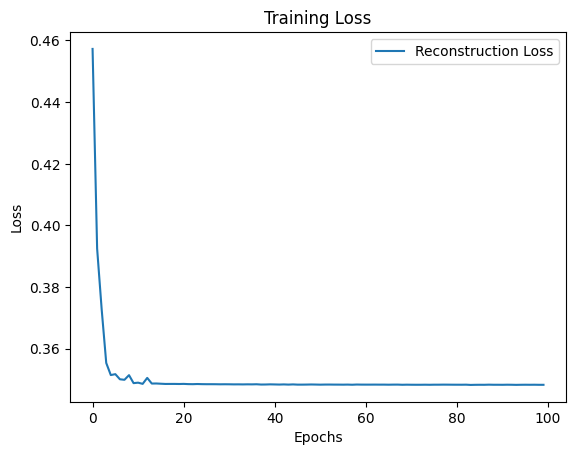

In [82]:
vqvae = VQVAE(embedding_dim=64, num_embeddings=512).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=1e-3)

# Training parameters
num_epochs = 100

# Training loop
vqvae.train()  # Set the model to training mode
reconstruction_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_loader:
        x, _ = batch  # Images only, no labels needed
        x = x.to(device)

        # Forward pass
        x_recon, z_e, z_q, _ = vqvae(x)

        # print("Input shape:", x.shape)
        # print("Reconstructed shape:", x_recon.shape)

        # Losses
        recon_loss = F.mse_loss(x_recon.view(x.size(0), -1), x.view(x.size(0), -1))# Reconstruction loss
        codebook_loss = F.mse_loss(z_q.detach(), z_e)  # Codebook loss
        commitment_loss = F.mse_loss(z_e, z_q.detach())  # Commitment loss

        # Total loss
        beta = 0.25  # Weight for commitment loss
        loss = recon_loss + codebook_loss + beta * commitment_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    reconstruction_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# ------------------------------------------
# Plot Reconstruction Loss
# ------------------------------------------
plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()



    






In [83]:
torch.save(vqvae, "vqvae_model.pth")


# Visualize the codebook
### Displays the learned embeddings as visual patterns

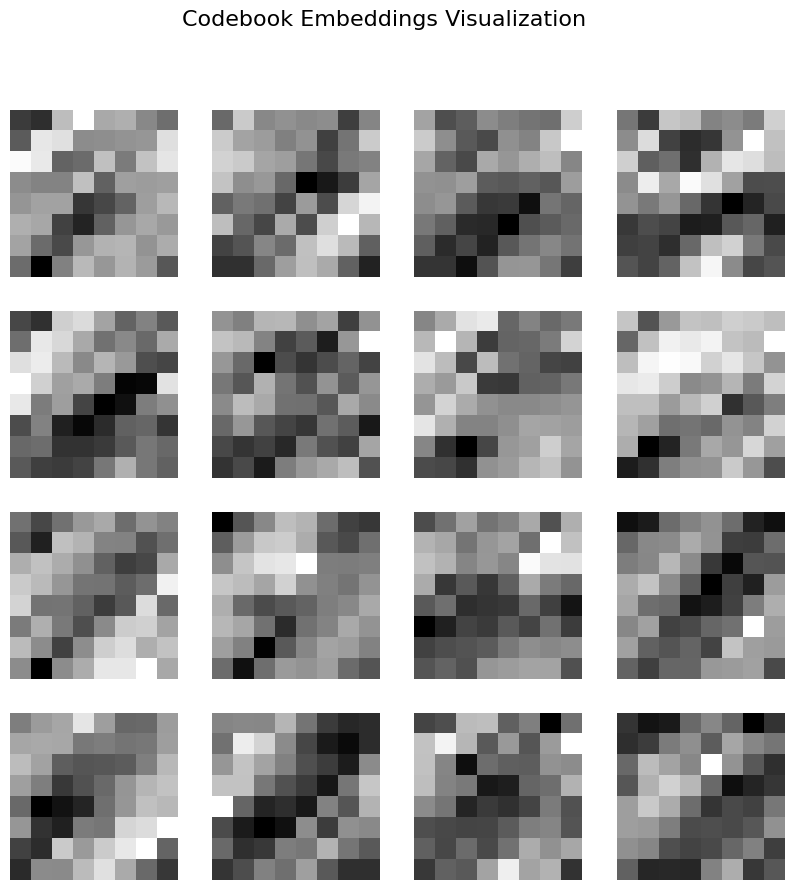

In [84]:
embedding_weights = vqvae.codebook.weight.detach().cpu().numpy()

# no of embeddings to visualize
num_embeddings = min(16, embedding_weights.shape[0]) # visualize 16 embeddings

# reshape embeddings for visulization if possible ( assume square shape is feasible)
embedding_dim = embedding_weights.shape[1]
side_dim = int(embedding_dim ** 0.5)

plt.figure(figsize=(10, 10))
for i in range(num_embeddings):
    plt.subplot(4, 4, i + 1)
    if embedding_dim == side_dim ** 2:  # Can reshape into square
        plt.imshow(embedding_weights[i].reshape(side_dim, side_dim), cmap='gray')
    else:  # Visualize as a bar plot if reshaping isn't possible
        plt.bar(range(embedding_dim), embedding_weights[i])
    plt.axis('off')

plt.suptitle("Codebook Embeddings Visualization", fontsize=16)
plt.show()







# Reconstructing  training data 

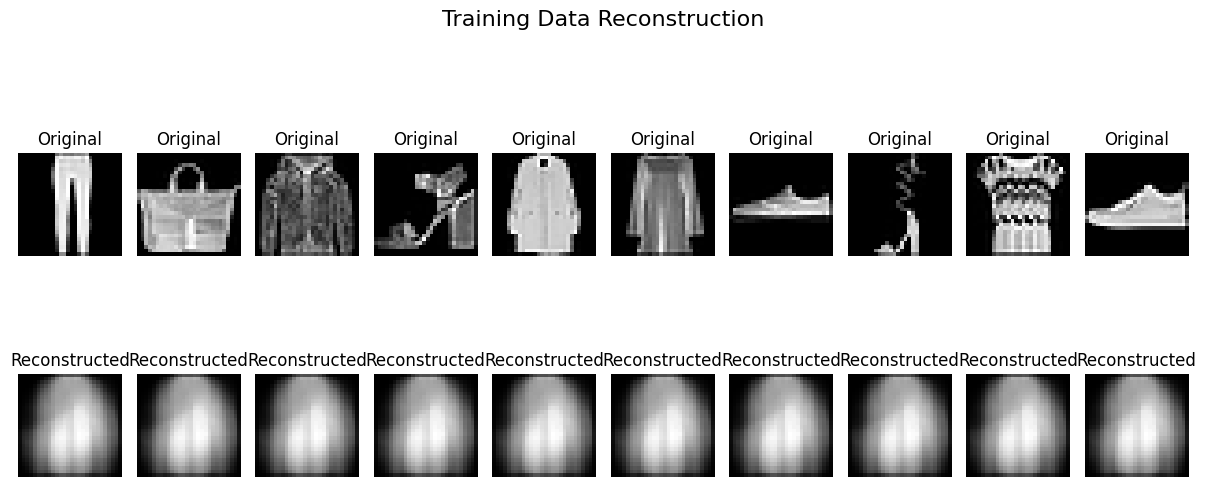

In [85]:
vqvae.eval()  # Set the model to evaluation mode

# get a batch of tarining data 
train_batch, _ = next(iter(train_loader)) # get a single batch from the training data 
train_batch = train_batch.to(device)
# pass through the model 

with torch.no_grad():
    recontructed_train, _, _, _ = vqvae(train_batch)

# Move tensors to CPU for visualization
train_batch = train_batch.cpu()
recontructed_train = recontructed_train.cpu()

# visualize the original and reconstructred training images 
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_batch[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Original")

    # Reconstructed image
    plt.subplot(2, 10, i + 11)
    plt.imshow(recontructed_train[i].squeeze(0), cmap='gray')
    plt.axis('off')
    plt.title("Reconstructed")

plt.suptitle("Training Data Reconstruction", fontsize=16)
plt.tight_layout()
plt.show()



## Reconstructing images using testing data for generalization

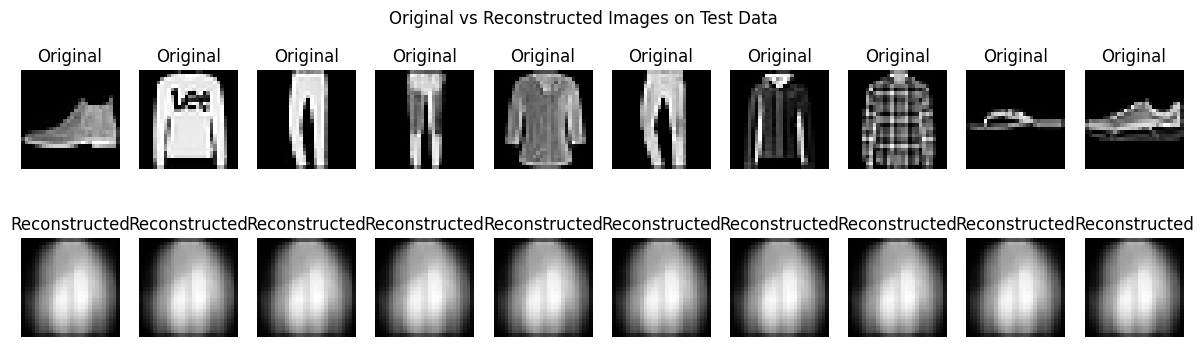

In [86]:
#Ensure the model is in evaluation mode
vqvae.eval()

# Visualize reconstructions from test data
with torch.no_grad():
    # Retrieve one batch of test images
    test_batch, _ = next(iter(test_loader))  # Ignore labels as VQ-VAE is unsupervised
    test_batch = test_batch.to(device)

    # Pass through the VQ-VAE model
    recon_batch, _, _, _ = vqvae(test_batch)

    # Move reconstructed images back to CPU
    recon_batch = recon_batch.cpu()

# Plot original and reconstructed images
num_images = 10  # Number of images to display
plt.figure(figsize=(15, 4))
for i in range(num_images):
    # Original test image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(test_batch[i].squeeze(0).cpu(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed test image
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(recon_batch[i].squeeze(0), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Original vs Reconstructed Images on Test Data")
plt.show()


# Generate New Images from VQ-VAE

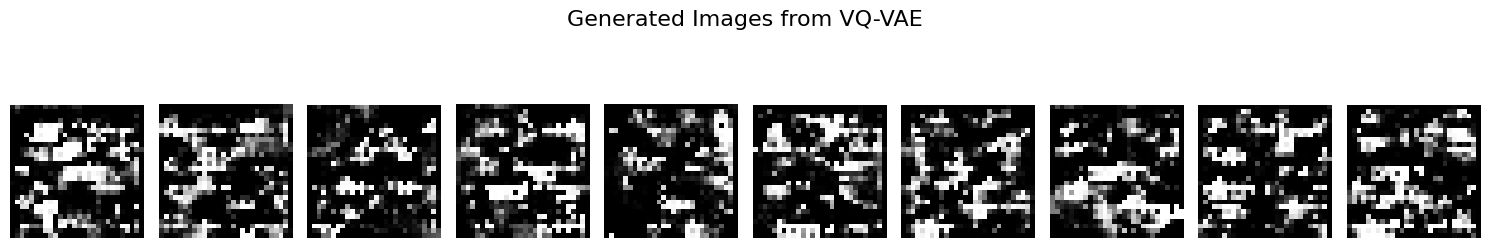

In [87]:
# Generate new images using VQ-VAE
vqvae.eval()  # Ensure the model is in evaluation mode

# Number of new images to generate
num_samples = 10
latent_dim = vqvae.codebook.embedding_dim  # Codebook embedding dimension
latent_shape = (7, 7)  # The spatial dimensions of the latent representation (e.g., 7x7 for Fashion MNIST)

# Sample random latent vectors from the standard normal distribution
z_random = torch.randn(num_samples, latent_dim, *latent_shape).to(device)

# Decode the latent vectors into new images
with torch.no_grad():
    generated_images = vqvae.decoder(z_random).cpu()

# Visualize the generated images
plt.figure(figsize=(15, 3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_images[i].squeeze(0), cmap='gray')  # Squeeze channel dimension
    plt.axis('off')
plt.suptitle("Generated Images from VQ-VAE", fontsize=16)
plt.tight_layout()
plt.show()


# Interpolation Using Two Points
### This interpolates between two random points in the latent space.

In [ ]:
vqvae.eval()  # Ensure the model is in evaluation mode

# Number of new images to generate
num_samples = 10

# Define latent space dimensions
latent_dim = vqvae.codebook.weight.size(1)   # Correctly access embedding dimension
latent_shape = (7, 7)  # Spatial dimensions of the latent representation

# Interpolate using two points
point_a = torch.randn(1, latent_dim, *latent_shape).to(device) # Random latent point A
point_b = torch.randn(1, latent_dim, *latent_shape).to(device) # Random latent point B

# Generate interpolated images
interpolated_images = []
num_steps = 10 # no of interpolation steps
for alpha in torch.linspace(0, 1, steps=num_steps):  # Linear interpolation between A and B
    z_interp = (1-alpha) * point_a + alpha * point_b
    with torch.no_grad():
        generated = vqvae.decoder(z_interp).cpu()
        interpolated_images.append(generated.squeeze(0))

# Visualize the interpolated images
plt.figure(figsize=(15, 3))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, num_steps, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Latent Space Interpolation (2 Points)", fontsize=16)
plt.tight_layout()
plt.show()



